In [168]:
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
import datetime
import numpy as np
df = pd.read_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/final report/dataset/dataset202402.csv", index_col=0)
df.head()
df["time_to_checkout"] = df["time_to_checkout"].map(
    lambda x: pd.to_timedelta(x))
df["time_to_checkout_hours"] = df["time_to_checkout"].map(
    lambda x: x/np.timedelta64(1, 'h'))
df.head()

,customer_id,actions,start_time,end_time,time_to_checkout,trade_order,hesitate,time_to_checkout_hours
0,++FIhbHyngN8aqKzA8CMRqChC6tQTKXhtDU+hg381mZNfe...,"['viewmainpage', 'viewmainpage', 'viewmainpage...",2024-02-25 23:58:02.980000000,2024-02-29 12:12:44.464000000,3 days 12:14:41.484000,jEbPPtt12/ykfvhRHiieDQ==,0,84.244857
6,++doREVuZr5K92Pn6JldYc5IEOxK87bMXH7k17DXfIfjKR...,"['viewproduct', 'viewproduct', 'add', 'vieweco...",2024-02-21 13:40:43.792999936,2024-02-21 14:02:08.567000064,0 days 00:21:24.774000128,OCtlXMHRpQgF7R7Qgr+pQw==,0,0.356882
8,++oPv+nfMMNpLcIyxFHVU4+xr3OuWVC51olWbpAYPQT8Ah...,"['viewmainpage', 'selectcontent', 'selectconte...",2024-02-29 08:48:08.900000000,2024-02-29 09:12:49.097999872,0 days 00:24:40.197999872,7T7uuoWUdmQKcv6NGTnBYA==,0,0.411166
10,++ro4mBltilmKQoZ1EoomFyZpqYdg2paWytjQULplyWhtv...,"['viewmainpage', 'viewecoupondetail', 'viewmai...",2024-02-07 19:18:42.263000064,2024-02-07 19:27:22.728000000,0 days 00:08:40.464999936,U6kl6NYaJKWE/T4StQipjw==,0,0.144574
13,++tNFD97NnjhNLDzZqgyZ6ib78s1wFUYAunkGRknnIbBeU...,"['viewmainpage', 'selectcontent', 'viewcustomp...",2024-02-12 22:09:47.228999936,2024-02-12 22:26:09.052000000,0 days 00:16:21.823000064,0b2JZZhDpi0WRM0Z2BgLrg==,0,0.272729


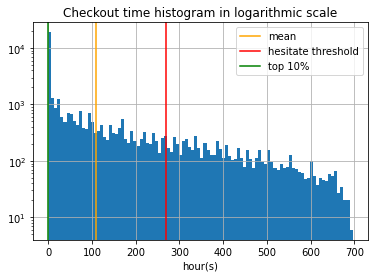

In [90]:
df.hist(column="time_to_checkout_hours", bins=100, log=True)
plt.xlabel("hour(s)")
plt.title("Checkout time histogram in logarithmic scale")
plt.axvline(x=df["time_to_checkout_hours"].mean(),label="mean" , color="orange")
plt.axvline(x=df["time_to_checkout_hours"].mean()+df["time_to_checkout_hours"].std(),label="hesitate threshold" , color="red")
plt.axvline(x=df["time_to_checkout_hours"].quantile(0.1), label="top 10%", color="green")
plt.legend()

In [80]:
actions = ["register", "viewmainpage", "viewcategory", "viewactivity", "viewcustompage", "viewalbumdetail", "viewvideodetail", "viewarticledetail",
           "viewecoupondetail", "viewpromotiondetail", "viewcoupondetail", "viewproduct", "search", "add", "checkout", "purchase", "selectcontent"]
actions = {k: v for v, k in enumerate(actions)}
n_actions = len(actions)
print("Action count:", n_actions)

Action count: 17


In [6]:
import torch


def action_to_index(action):
    return actions[action]


def sequence_to_tensor(sequence):
    tensor = torch.zeros(len(sequence), 1, n_actions)
    for index, action in enumerate(sequence):
        tensor[index][0][action_to_index(action)] = 1
    return tensor


def label_to_tensor(label: int):
    tensor = torch.nn.functional.one_hot(
        torch.tensor(label), 2)  # binary classification
    return tensor

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

normal: 35443 hesitate: 6916


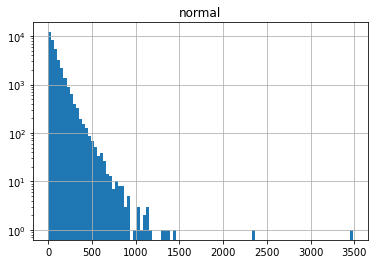

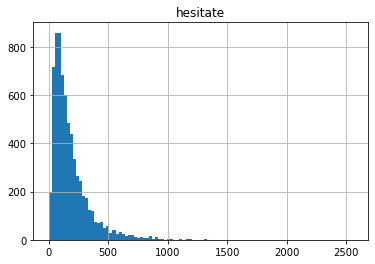

In [91]:
import random
import ast
random.seed(42)

df["actions_length"] = df["actions"].apply(lambda x: len(ast.literal_eval(x)))

normal_df = df[df["hesitate"] == 0]
hesitate_df = df[df["hesitate"] == 1]

print("normal:", len(normal_df.index), "hesitate:", len(hesitate_df.index))


normal_df.hist(column=["actions_length"],  bins=100, log=True)
plt.title("normal")
hesitate_df.hist(column=["actions_length"], bins=100, log=False)
plt.title("hesitate")

train_df = pd.concat([normal_df[:5000], hesitate_df[:5000]])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_df = pd.concat([normal_df[5000:5100], hesitate_df[5000:5100]])

In [9]:
print(torch.cuda.is_available())  # Should return True

True


In [92]:
from tqdm import tqdm
input_size = len(actions)
hidden_size = 64
num_layers = 4
output_size = 2
model = LSTMClassifier(input_size, hidden_size,
                       num_layers, output_size).to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for _, sample in tqdm(train_df.iterrows(), total=len(train_df.index), desc=f"Training on epoch {epoch+1}"):
        optimizer.zero_grad()
        sequence_tensor = sequence_to_tensor(
            ast.literal_eval(sample["actions"]))
        sequence_tensor = sequence_tensor.to("cuda")
        if (len(sequence_tensor) == 0):
            continue
        sequence_tensor = torch.reshape(sequence_tensor, (1, -1, input_size))
        outputs = model(sequence_tensor)
        label_tensor = label_to_tensor(sample["hesitate"])
        label_tensor = label_tensor.to(
            "cuda", dtype=torch.float64).reshape((1, 2))
        loss = criterion(outputs, label_tensor)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    total = len(test_df.index)
    correct = 0
    for _, row in tqdm(test_df.iterrows(), total=len(test_df.index),  desc="Evaluating model performace"):
        sequence_tensor = sequence_to_tensor(
            ast.literal_eval(row["actions"]))
        if (len(sequence_tensor) == 0):
            total -= 1
            continue
        sequence_tensor = sequence_tensor.to(
            "cuda").reshape((1, -1, input_size))

        with torch.no_grad():
            predicted_tensor = model(sequence_tensor)
        predicted = predicted_tensor.argmax()
        if predicted == row["hesitate"]:
            correct += 1
    print(f"Accuracy:{correct / total:.2f}",)

Training on epoch 1: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:06<00:00, 150.13it/s]


Epoch [1/10], Loss: 0.6303070783615112


Evaluating model performace: 100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 291.65it/s]


Accuracy:0.50


Training on epoch 2: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:14<00:00, 133.88it/s]


Epoch [2/10], Loss: 0.5566504597663879


Evaluating model performace: 100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 321.79it/s]


Accuracy:0.64


Training on epoch 3: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:27<00:00, 114.78it/s]


Epoch [3/10], Loss: 0.45174816250801086


Evaluating model performace: 100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 242.49it/s]


Accuracy:0.60


Training on epoch 4: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 138.50it/s]


Epoch [4/10], Loss: 0.37758007645606995


Evaluating model performace: 100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 272.04it/s]


Accuracy:0.67


Training on epoch 5: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 138.10it/s]


Epoch [5/10], Loss: 0.19378575682640076


Evaluating model performace: 100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 317.86it/s]


Accuracy:0.64


Training on epoch 6: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 135.71it/s]


Epoch [6/10], Loss: 0.23374031484127045


Evaluating model performace: 100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 323.16it/s]


Accuracy:0.71


Training on epoch 7: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:20<00:00, 123.84it/s]


Epoch [7/10], Loss: 0.13315345346927643


Evaluating model performace: 100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 185.48it/s]


Accuracy:0.74


Training on epoch 8: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:28<00:00, 112.71it/s]


Epoch [8/10], Loss: 0.09585267305374146


Evaluating model performace: 100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 233.09it/s]


Accuracy:0.78


Training on epoch 9: 100%|██████████████████████████████████████████████████████| 10000/10000 [01:32<00:00, 107.72it/s]


Epoch [9/10], Loss: 0.16664867103099823


Evaluating model performace: 100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 264.05it/s]


Accuracy:0.73


Training on epoch 10: 100%|█████████████████████████████████████████████████████| 10000/10000 [01:17<00:00, 129.52it/s]


Epoch [10/10], Loss: 0.1296669840812683


Evaluating model performace: 100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 317.10it/s]

Accuracy:0.76


In [142]:
def predict(row, model):
    sequence_tensor = sequence_to_tensor(
        ast.literal_eval(row["actions"]))
    if (len(sequence_tensor) == 0):
        print("warning: action sequence length == 0")
        return 0
    sequence_tensor = sequence_tensor.to(
        "cuda").reshape((1, -1, input_size))

    with torch.no_grad():
        predicted_tensor = model(sequence_tensor)
    predicted = predicted_tensor.argmax()
    #print("user actions:", row["actions"],
     #     "predicted behavior:", "hesitate" if predicted == 1 else "normal")
    return predicted.item()

for _, row in test_df.sample(n=10).iterrows():
    predict(row, model)

In [76]:
print("LSTM Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

LSTM Model's state_dict:
lstm.weight_ih_l0 	 torch.Size([256, 17])
lstm.weight_hh_l0 	 torch.Size([256, 64])
lstm.bias_ih_l0 	 torch.Size([256])
lstm.bias_hh_l0 	 torch.Size([256])
lstm.weight_ih_l1 	 torch.Size([256, 64])
lstm.weight_hh_l1 	 torch.Size([256, 64])
lstm.bias_ih_l1 	 torch.Size([256])
lstm.bias_hh_l1 	 torch.Size([256])
lstm.weight_ih_l2 	 torch.Size([256, 64])
lstm.weight_hh_l2 	 torch.Size([256, 64])
lstm.bias_ih_l2 	 torch.Size([256])
lstm.bias_hh_l2 	 torch.Size([256])
lstm.weight_ih_l3 	 torch.Size([256, 64])
lstm.weight_hh_l3 	 torch.Size([256, 64])
lstm.bias_ih_l3 	 torch.Size([256])
lstm.bias_hh_l3 	 torch.Size([256])
fc.weight 	 torch.Size([2, 64])
fc.bias 	 torch.Size([2])


In [93]:
torch.save(model.state_dict(), "./model2402.bin")

In [186]:
def predicted_df(df):
    temp = []
    for _, row in df.iterrows():
        prediction = predict(row, loaded_model)
        temp.append(int(prediction))
    temp = np.array(temp)
    df['prediction'] = temp
    return df

In [183]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(df, file_path):
    cm = confusion_matrix(df['hesitate'], df['prediction'])

    # 将混淆矩阵转换为DataFrame以便于展示
    cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig(file_path)
    plt.show()
    return

In [216]:
# load model
loaded_model = LSTMClassifier(input_size, hidden_size,
                              num_layers, output_size).to("cuda")
loaded_model.load_state_dict(torch.load("./model2310.bin"))
loaded_model.eval()

LSTMClassifier(
  (lstm): LSTM(17, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
valid_data = pd.read_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/final report/dataset/dataset202311.csv", index_col=0)
valid_data = predicted_df(valid_data)
file_path = 'C:/Users/Bryce Chiu/Desktop/大數據與商業分析/final report/figure/confusion_matrix' + '2311.png'
plot_confusion_matrix(valid_data, file_path)
valid_data.to_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/final report/dataset/predicted_dataset202311.csv")

In [218]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

accuracy = accuracy_score(valid_data['hesitate'], valid_data['prediction'])
f1 = f1_score(valid_data['hesitate'], valid_data['prediction'], average='weighted')
precision = precision_score(valid_data['hesitate'], valid_data['prediction'], average='weighted')
recall = recall_score(valid_data['hesitate'], valid_data['prediction'], average='weighted')

print('2311 data prediction result:')
print(f"total number: {len(valid_data['hesitate'])}")
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


2311 data prediction result:
total number: 35749
Accuracy: 0.7356569414529077
F1 score: 0.7707771753272088
Precision: 0.8672425410292327
Recall: 0.7356569414529077
